In [1]:
import datetime
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import torchvision.datasets as datasets
from torchvision.utils import make_grid
from art.attacks.evasion import BasicIterativeMethod
from art.estimators.classification import PyTorchClassifier
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from region_based_classifier import RegionBasedClassifier
from util import dataset2tensor, get_correct_examples

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))

n_threads = os.cpu_count()
print('CPU threads: {}'.format(n_threads))

Device: cuda
CPU threads: 24


In [4]:
PATH_DATA = 'data'
BATCH_SIZE = 256
EPOCHS = 100

In [5]:
# Fetch dataset
transforms = tv.transforms.Compose([tv.transforms.ToTensor()])
dataset_train = datasets.MNIST(PATH_DATA, train=True, download=True, transform=transforms)
dataset_test = datasets.MNIST(PATH_DATA, train=False, download=True, transform=transforms)

# Split the origional training set into training set and validation set
# From PyTorch dataset to Numpy array
tensor_X_train, tensor_y_train = dataset2tensor(dataset_train)
X_train = tensor_X_train.cpu().detach().numpy()
y_train = tensor_y_train.cpu().detach().numpy()

# Split model training set into training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=5000)
dataset_train = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.int64))
dataset_val = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.int64))

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

print(len(dataset_train), len(dataset_val), len(dataset_test))

55000 5000 10000


## Creating Autoencoders

In [6]:
class Autoencoder1(nn.Module):
    def __init__(self, n_channel=1):
        super(Autoencoder1, self).__init__()
        self.n_channel = n_channel
        self.conv1 = nn.Conv2d(self.n_channel, 3, 3, padding=1)
        self.conv2 = nn.Conv2d(3, 3, 3, padding=1)
        self.conv3 = nn.Conv2d(3, 3, 3, padding=1)
        self.conv4 = nn.Conv2d(3, 3, 3, padding=1)
        self.conv5 = nn.Conv2d(3, self.n_channel, 3, padding=1)
    
    def forward(self, x):
        x = F.sigmoid(self.conv1(x))
        x = F.avg_pool2d(x, kernel_size=2)
        x = F.sigmoid(self.conv2(x))
        x = F.sigmoid(self.conv3(x))
        x = F.upsample(x, scale_factor=2)
        x = F.sigmoid(self.conv4(x))
        x = F.sigmoid(self.conv5(x))
        return x

In [7]:
ae1 = Autoencoder1().to(device)
ae1.eval()
x, _ = next(iter(dataloader_test))
print(x.size())
x = x.to(device)
output = ae1(x)
print(output.size())

torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])


In [8]:
class Autoencoder2(nn.Module):
    def __init__(self, n_channel=1):
        super(Autoencoder2, self).__init__()
        self.n_channel = n_channel
        self.conv1 = nn.Conv2d(self.n_channel, 3, 3, padding=1)
        self.conv2 = nn.Conv2d(3, 3, 3, padding=1)
        self.conv3 = nn.Conv2d(3, self.n_channel, 3, padding=1)

    def forward(self, x):
        x = F.sigmoid(self.conv1(x))
        x = F.sigmoid(self.conv2(x))
        x = F.sigmoid(self.conv3(x))
        return x

In [9]:
ae2 = Autoencoder2().to(device)
ae2.eval()
x, _ = next(iter(dataloader_test))
print(x.size())
x = x.to(device)
output = ae1(x)
print(output.size())

torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])


In [10]:
optimizer_ae1 = optim.AdamW(ae1.parameters(), lr=0.001, weight_decay=1e-9)
loss = nn.MSELoss()

In [11]:
def train(model, loader, loss, optimizer, device):
    n = len(loader.dataset)
    model.train()
    total_loss = 0.0

    for x, _ in loader:
        x = x.to(device)
        batch_size = x.size(0)

        optimizer.zero_grad()
        outputs = model(x)
        l = loss(outputs, x)
        l.backward()
        optimizer.step()
        total_loss += l.item() * batch_size
    total_loss = total_loss / float(n)
    return total_loss

In [12]:
def validate(model, loader, loss, device):
    n = len(loader.dataset)
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            batch_size = x.size(0)
            outputs = model(x)
            l = loss(outputs, x)
            total_loss += l.item() * batch_size
    total_loss = total_loss / float(n)
    return total_loss

In [13]:
def fit(model, dataloader_train, dataloader_val, loss, optimizer, max_epochs, device):
    history_tr_loss = np.zeros(max_epochs, dtype=np.float32) 
    history_va_loss = np.zeros(max_epochs, dtype=np.float32) 

    for epoch in tqdm(range(max_epochs)):
        history_tr_loss[epoch] = train(model, dataloader_train, loss, optimizer, device)
        history_va_loss[epoch] = validate(model, dataloader_val, loss, device)

    return history_tr_loss, history_va_loss

In [14]:
# Train encoder
tr_losses, va_losses = fit(ae1, dataloader_train, dataloader_val, loss, optimizer_ae1, EPOCHS, device)

100%|██████████| 100/100 [01:24<00:00,  1.18it/s]


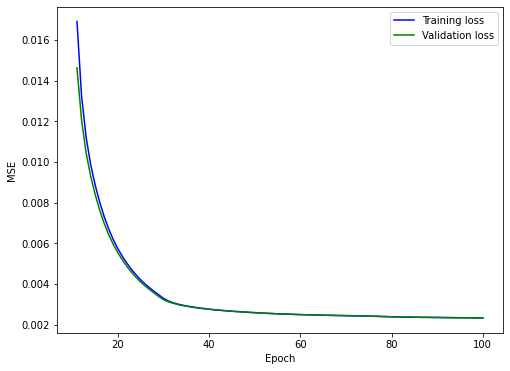

In [20]:
plt.figure(figsize=(8, 6))
x = np.arange(1, EPOCHS+1)
plt.plot(x[10:], tr_losses[10:], c='blue', label='Training loss')
plt.plot(x[10:], va_losses[10:], c='green', label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()


In [16]:
# Save results
if not os.path.exists('results'):
    os.makedirs('results')
PATH_AUTOENCODER1 = os.path.join('results', 'ae1.pt')
torch.save(ae1.state_dict(), PATH_AUTOENCODER1)

In [17]:
# Load results
ae1.load_state_dict(torch.load(PATH_AUTOENCODER1))

In [18]:
images, _ = next(iter(dataloader_train))
print(images.size())
images = images[:10]

ae1.eval()
ae_images = ae1(images.to(device))
print(ae_images.size())

images = make_grid(images).permute(1, 2, 0).cpu().detach().numpy()
ae_images = make_grid(ae_images).permute(1, 2, 0).cpu().detach().numpy()

print(images.shape)
print(ae_images.shape)

torch.Size([256, 1, 28, 28])
torch.Size([10, 1, 28, 28])
(62, 242, 3)
(62, 242, 3)


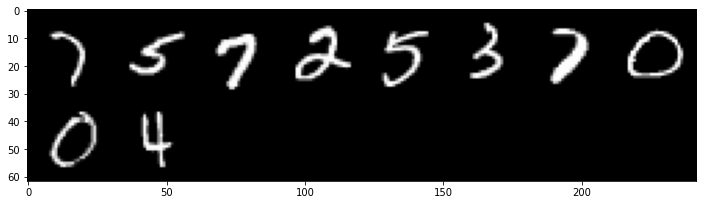

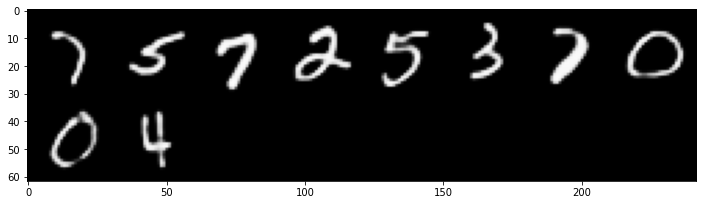

In [19]:
plt.figure(figsize=(12, 6))
plt.imshow(images)
plt.show()

plt.figure(figsize=(12, 6))
plt.imshow(ae_images)
plt.show()